# Prep

In [1]:
pkgs = c(
    'tidyverse',
    'lubridate',
    'patchwork',
    'ggpmisc'
)

for(pkg in pkgs) {
    if(! require(pkg, character.only = TRUE)) {
        install.packages(pkg)
        require(pkg, character.only = TRUE)
    }
}

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: patchwork

Loading required package: ggpmisc

Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate




# Utils

In [2]:
figsize = \(width=8,height=6) 
    options(repr.plot.width=width, repr.plot.height=height)

In [3]:
# https://www.niid.go.jp/niid/ja/calendar/9261-idwr-calendar-2020.html
yw2date = data.frame(date = full_seq(ym(c(201001, 205001)), period=1)) %>%
    mutate(
        year = isoyear(date),
        week = isoweek(date),
    ) %>%
    group_by(year,week) %>%
    summarise_all(last) %>%
    ungroup
head(yw2date)

year,week,date
<dbl>,<dbl>,<date>
2009,53,2010-01-03
2010,1,2010-01-10
2010,2,2010-01-17
2010,3,2010-01-24
2010,4,2010-01-31
2010,5,2010-02-07


# Effective reproduction number of Flu in Japan

In [4]:
# https://www.nature.com/articles/s41598-019-39057-w
flu.mean = 2.6
flu.var = 1.5^2

# https://www.niid.go.jp/niid/ja/data.html
flu.weekly = read_csv('data/japan-flu-per-sentinel-weekly.csv') %>%
    { colnames(.)[1] = 'year'; . } %>%
    mutate(
        across(where(is.character), ~ str_extract(., '[+-]?\\d+') %>% as.numeric)
    ) %>%
    pivot_longer(!year, names_to='week', values_to='p') %>% 
    mutate(
        year = 2000 + year,
        week = str_extract(week, '\\d+') %>% as.numeric,
        r = ifelse(p == 0 | lag(p) == 0, NA, (p/lag(p))^(1/7) - 1),
        Re = (1+r*flu.var/flu.mean)^(flu.mean^2/flu.var)
    ) %>% 
    left_join(yw2date, by=c('year', 'week')) %>%
    mutate(
        month = month(date)
    ) %>%
    filter(!is.na(month))

head(flu.weekly)

New names:
• `` -> `...1`
Rows: 11 Columns: 54
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): ...1, 32週, 34週, 36週
dbl (50): 1週, 2週, 3週, 4週, 5週, 6週, 7週, 8週, 9週, 10週, 11週, 12週, 13週, 14週, 15週, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,week,p,r,Re,date,month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
2013,1,3.91,NA,NA,2013-01-06,1
2013,2,12.07,0.174716125,1.5265827,2013-01-13,1
2013,3,22.58,0.093602574,1.2636596,2013-01-20,1
2013,4,36.44,0.070763331,1.1955080,2013-01-27,1
2013,5,35.82,-0.002448523,0.9936474,2013-02-03,2
2013,6,26.70,-0.041108690,0.8968828,2013-02-10,2


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 153 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 54 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 192 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 192 rows containing missing values (`geom_point()`).”


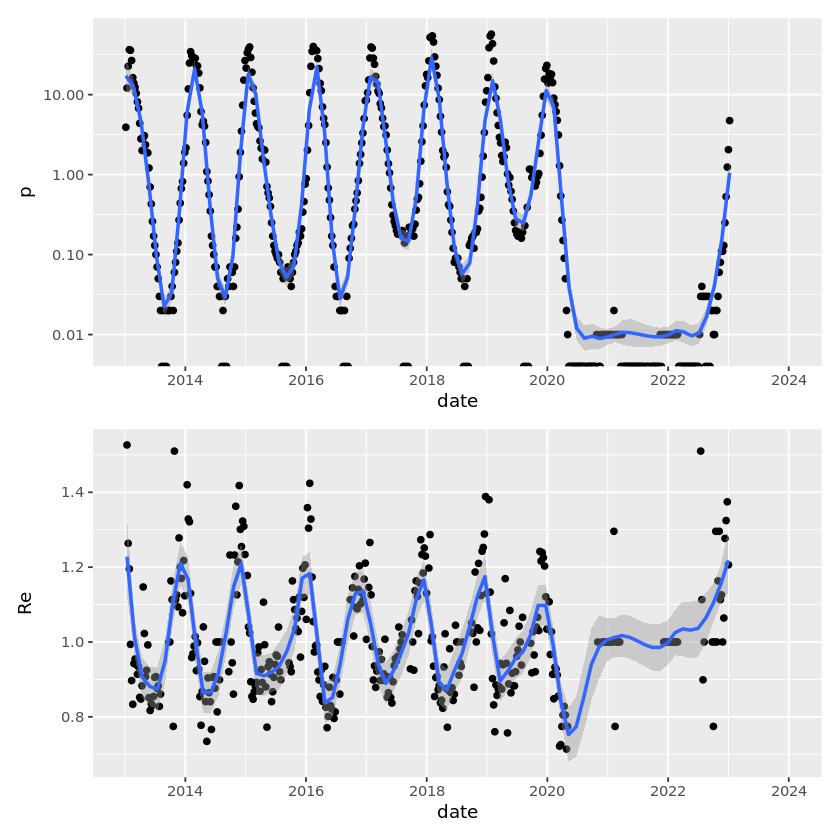

In [5]:
g.p = flu.weekly %>%
    ggplot(aes(date, p)) +
    geom_point() +
    geom_smooth(method='loess', span=52/nrow(flu.weekly)) +
    scale_y_log10()

g.Re = flu.weekly %>%
    ggplot(aes(date, Re)) +
    geom_point() +
    geom_smooth(method='loess', span=52/nrow(flu.weekly))

g.p / g.Re

Warning message:
“Removed 48 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”


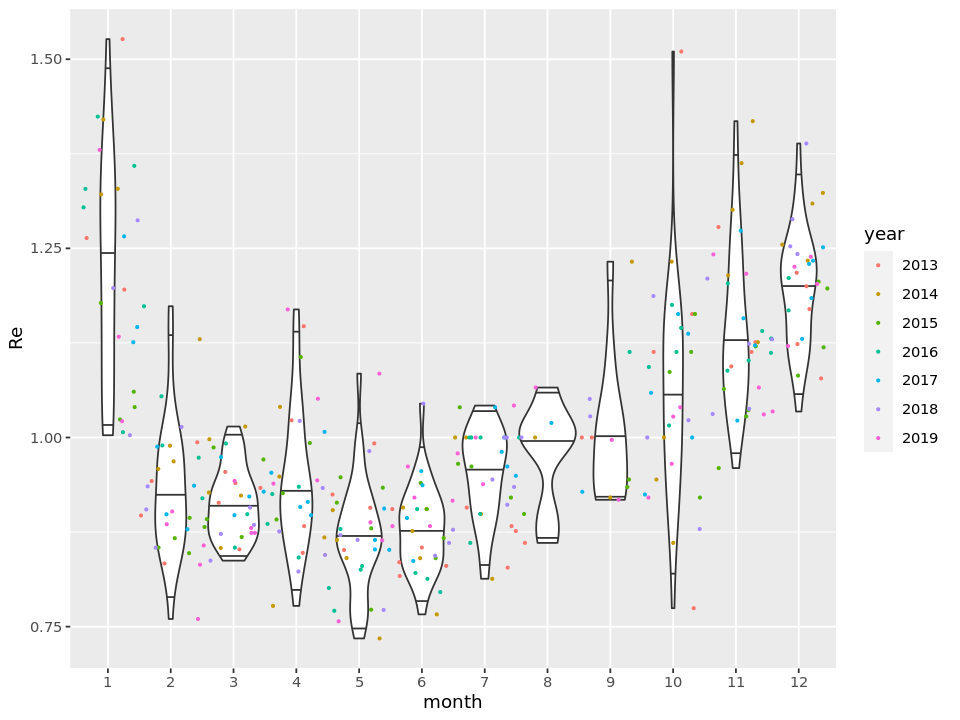

In [6]:
figsize(8,6)
flu.weekly %>%
    filter(year < 2020) %>%
    mutate(across(c(month, year), ~ factor(.))) %>%
ggplot(aes(month, Re)) +
    geom_violin(draw_quantiles=c(.025, .5, .975)) +
    geom_jitter(aes(color=year), size=.5, width=.5)

In [7]:
flu.weekly %>%
    filter(year < 2020) %>%
    mutate(month = month %>% as.integer) %>%
    group_by(month) %>%
    summarize(Re=mean(Re, na.rm=TRUE)) %>%
    { show(.); . } %>%
    write_csv('data/flu-Re-monthly.csv')

# A tibble: 12 × 2
   month    Re
   <int> <dbl>
 1     1 1.22 
 2     2 0.934
 3     3 0.913
 4     4 0.944
 5     5 0.871
 6     6 0.879
 7     7 0.953
 8     8 0.978
 9     9 1.01 
10    10 1.06 
11    11 1.14 
12    12 1.20 


# Immunity factor $\lambda$
With heterogeneic susceptibility of population, 
epidemic dynamic differs from simple compartment model.
We use [Tkachenko et al.](https://www.pnas.org/doi/10.1073/pnas.2015972118) as 
$$
\def\d{{\,\rm d}}
\def\D#1#2{\frac{\d #1}{\d #2}}
\def\<{\left<}
\def\>{\right>}
\def\[{\left[}
\def\]{\right]}
\def\R{{\mathcal R}}
\def\E{{\mathbb E}}
\def\V{{\mathbb V}}
\begin{align}
\D{S_a}{t} & = - \beta a S_a J = - j_a \\
J & = \int \R_a \int^t K(s) j_a(t-s)  \d s f(a) \d a \\
& = \<\R_a \[K, j_a\]\> \\
& = \[K, \R_e J\]
\end{align}
$$
where
- susceptibility $a \sim f(a)$, 
- susceptible population rate $S_a(t)$ with susceptibility $a$,
- infectivity $\R_a$ of sub-population $S_a$,
- force of infection $J(t)$,
- generation interval distribution $K(s)$, and
- effective reproduction number $\R_e(t) = \beta \<a \R_a S_a(t)\>$.

Since we want to estiamte weekly/monthly reproduction number,
the variation of $\R_e$ can be assumed to be negligible over generation interval, say
$$
J = \[K, \R_e J\] = \R_e \[K, J\].
$$
This gives us the well-known result to calculate $\R_e$ :
$$
\R_e(t) = \frac{1}{M_K(-r(t))}
$$
where moment generating function $M_K$ of $K$ and instantaneous growth rate $r(t) = \D{\log(J(t))}{t}$. Now we have two-ways to calculate $\R_e$ by using $f(a)$ and $K(s)$ respectively, and both are supposed to be equal: 
$$
\beta \<a \R_a S_a(t)\> = \frac{1}{M_K(-r(t))}.
$$

If we assume 
- $\chi \in \[0,1\]$,
- $\R_a = a^\chi$,
- $f(a) \sim \Gamma({\rm shape}=k, {\rm scale}=1/k)$, and
- $K(s) \sim \Gamma({\rm mean}=\E\[s\], {\rm var}=\V\[s\])$,

there is closed form as 
$$
\R_0 S(t)^\lambda = (1+r(t)\theta)^{\E\[s\] / \theta} = \R_e(t)
$$
where 
- immunity factor $\lambda = 1 + (1+\chi)/k$,
- basic reproduction number $\R_0 = \beta (1+1/k)$,
- susceptible population rate $S = \<S_a\>$, and
- scale paramter $\theta = \V\[s\] / \E\[s\]$ of $K$.

Now immunity factor $\lambda$(and $\R_0$) can be estimated by fitting linear regression $\log(\R_e) \sim \log(S)$.

In [8]:
flu.total = read_csv("data/japan-flu-total-per-season.csv") %>%
    separate(from, c('from.year', 'from.week'), convert=TRUE) %>%
    separate(to, c('to.year', 'to.week'), convert=TRUE) %>%
    mutate(
        from.yw = from.year * 100 + from.week,
        to.yw = to.year * 100 + to.week
    )
head(flu.total)

Rows: 10 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): from, to
num (1): total

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


from.year,from.week,to.year,to.week,total,from.yw,to.yw
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
2020,36,2021,17,14000,202036,202117
2019,36,2020,17,7289000,201936,202017
2018,36,2019,17,12000000,201836,201917
2017,36,2018,17,14843400,201736,201817
2016,36,2017,20,11193600,201636,201720
2015,36,2016,20,10645800,201536,201620


In [9]:
flu.combined = c()
for(i in 1:nrow(flu.total)) {
    row = flu.total[i,]
    flu.weekly %>%
        mutate(yw = year*100+week) %>%
        filter(row$from.yw <= yw & yw <= row$to.yw) %>%
        mutate(
            n = p/sum(p, na.rm=TRUE)*row$total,
            season = i
        ) %>%
        { flu.combined <<- rbind(flu.combined, .) }
}
flu.combined = flu.combined %>%
    group_by(season) %>%
    mutate(
        S = 1-cumsum(replace_na(n,0))/126e6
    ) %>%
    ungroup()
head(flu.combined)

year,week,p,r,Re,date,month,yw,n,season,S
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2020,36,0,NA,NA,2020-09-06,9,202036,0,1,1
2020,37,0,NA,NA,2020-09-13,9,202037,0,1,1
2020,38,0,NA,NA,2020-09-20,9,202038,0,1,1
2020,39,0,NA,NA,2020-09-27,9,202039,0,1,1
2020,40,0,NA,NA,2020-10-04,10,202040,0,1,1
2020,41,0,NA,NA,2020-10-11,10,202041,0,1,1


Warning message:
“Transformation introduced infinite values in continuous y-axis”


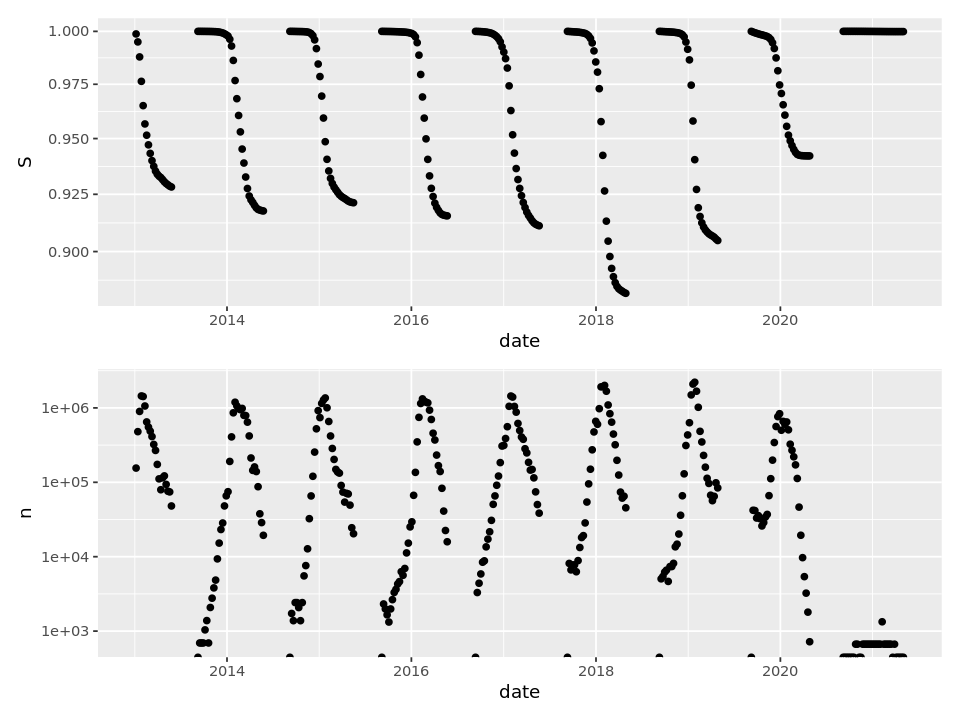

In [10]:
g.S = ggplot(flu.combined) +
    geom_point(aes(date, S)) +
    scale_y_log10()
g.n = ggplot(flu.combined) +
    geom_point(aes(date, n)) +
    scale_y_log10()
g.S / g.n

Warning message:
“Removed 39 rows containing non-finite values (`stat_poly_line()`).”
Warning message:
“Removed 39 rows containing non-finite values (`stat_poly_eq()`).”
Warning message:
“Removed 39 rows containing missing values (`geom_point()`).”


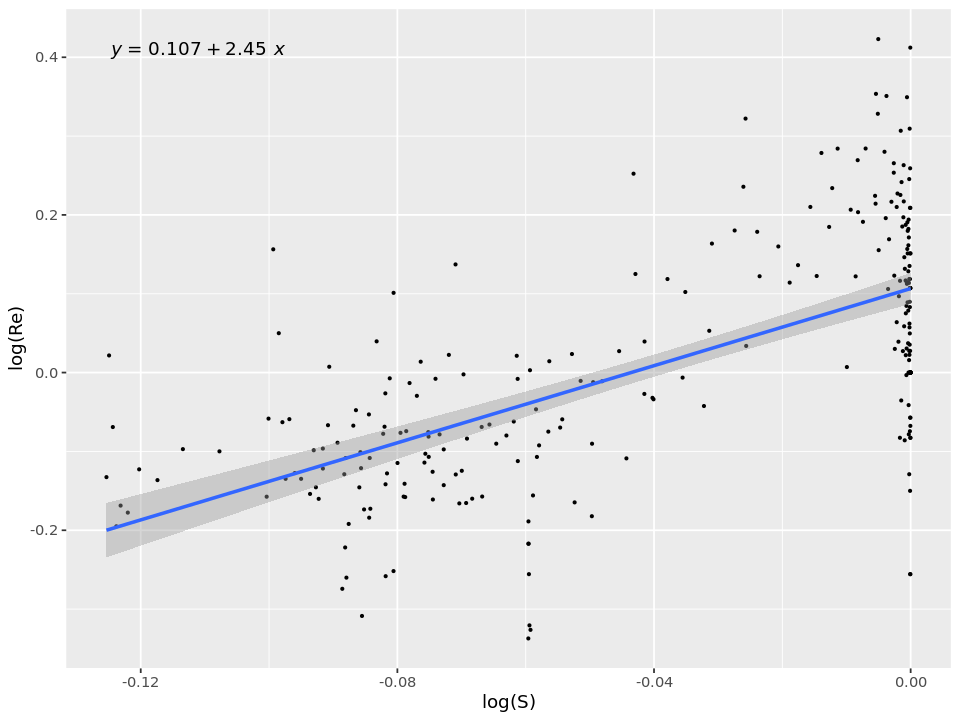

In [11]:
flu.combined %>%
    ggplot(aes(log(S), log(Re))) +
    geom_point(size=.5) +
    stat_poly_line(method='lm') +
    stat_poly_eq(method='lm', aes(label=after_stat(eq.label)))

Warning message:
“Removed 5 rows containing non-finite values (`stat_poly_line()`).”
Warning message:
“Removed 5 rows containing non-finite values (`stat_poly_eq()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


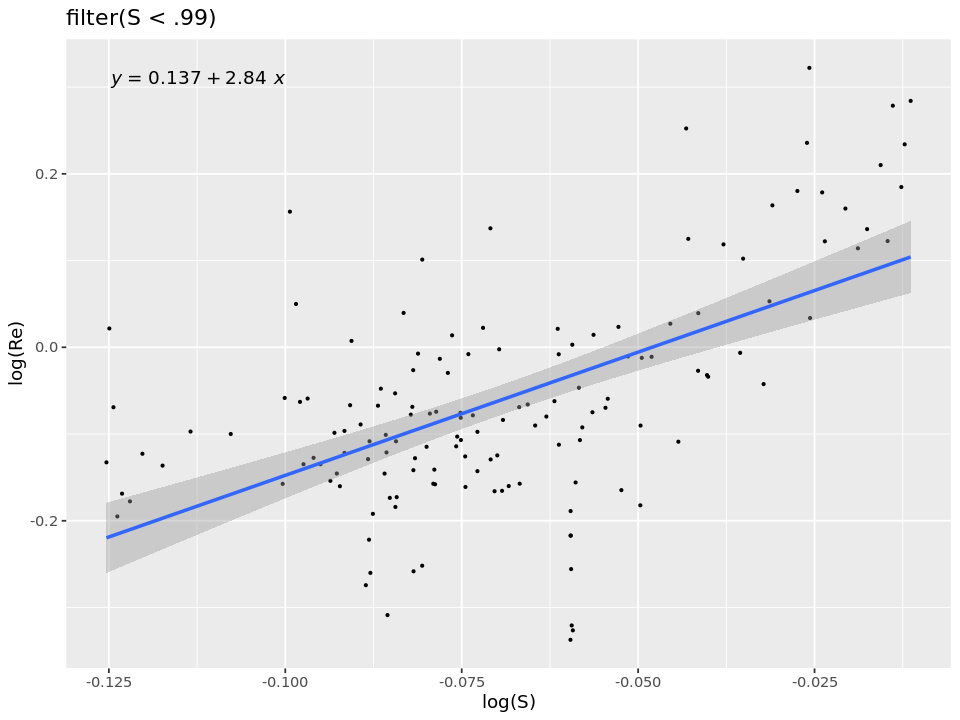

In [12]:
flu.combined %>%
    filter(S < .99) %>%
    ggplot(aes(log(S), log(Re))) +
    geom_point(size=.5) +
    stat_poly_line(method='lm') +
    stat_poly_eq(method='lm', aes(label=after_stat(eq.label))) +
    labs(title = 'filter(S < .99)')

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 39 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 39 rows containing missing values (`geom_point()`).”


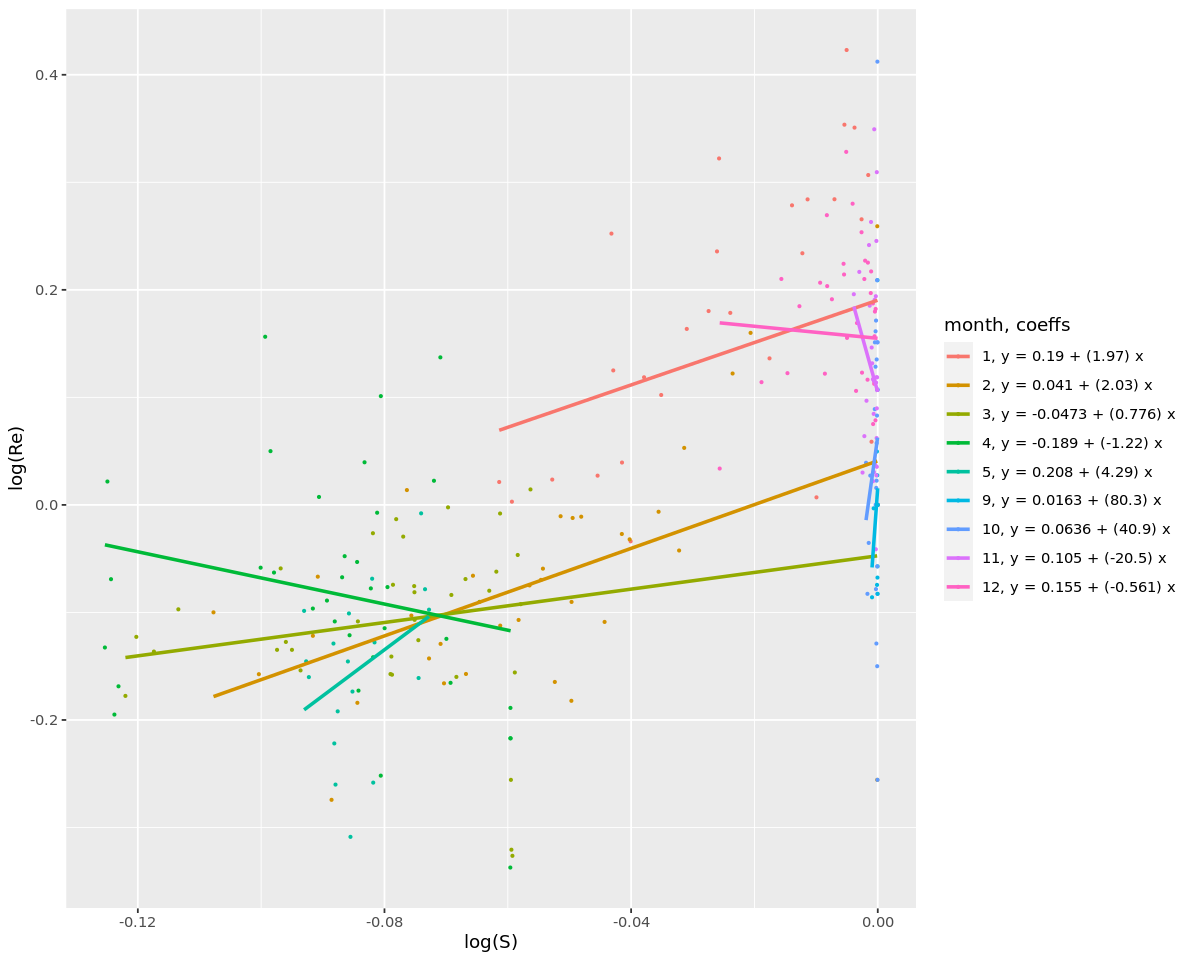

In [13]:
figsize(10,8)
flu.combined %>%
    group_by(month) %>%
    mutate(
        label = {
            m = lm(log(Re) ~ log(S), data = pick(everything()))
            coef = m$coefficients
            label = str_interp('${month[1]}, y = ${signif(coef[1],3)} + (${signif(coef[2],3)}) x')
            factor(label, levels = str_sort(unique(label), numeric=TRUE))
        }
    ) %>%
    ggplot(aes(log(S), log(Re), color=label)) +
    geom_point(size=.5) +
    geom_smooth(method='lm', se=FALSE) +
    labs(color='month, coeffs')